In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sqlite3    ## SQL Interface
import pickle     ## Used to save your data - Converts objects to byte stream and vice versa
import time

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

import gensim    ## Word Embeddings

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Read the cleaned sqlite file

In [2]:
conn = sqlite3.connect('../8. Amazon_New/final.sqlite')
final = pd.read_sql_query("""SELECT * FROM Reviews""", conn)
conn.close()
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...


### Read the list_of_sent created during EDA and cleaning

In [3]:
with open('../8. Amazon_New/list_of_sent_for_input_to_w2v.pkl', 'rb') as pickle_file:
    list_of_sent = pickle.load(pickle_file)

#### Training the Word2Vec model for words with min count 5¶
Reference for intuition - https://www.tensorflow.org/tutorials/word2vec

In [4]:
## size is the no of dimensions
## min_count specifies the min no of times a word needs to occur to be included in the model
## workers is the number of cores on your PC
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers=-1)

## Function to calculate Avg Word2Vec

In [5]:
def calc_avg_w2v(list_of_sent, w2v_model):
    '''This function takes in 2 parameters as follows:
       1. list_of_sent - This is the list of sentences/reviews for which sentence vetors are to be constructed
       2. w2v_model - This is the Word2Vec model which is trained on the working corpus - contains the word vectors
       
       Return Value:
       sent_vectors - This is a list of sentence/review vectors constructed by averaging the word vectors
    '''
    
    ## Initialize an empty list
    sent_vectors = []
    
    ## Consider one sentence/review at a time
    for sent in list_of_sent:
        ## Initialize sentence vector to 0
        ## Note: Size of the vector must match the no. of dimensions used in word2vec model
        sent_vec = np.zeros(100)
        
        ## Initialize count of words to 0
        cnt_words = 0
        
        ## Consider the words one by one
        for word in sent:
            try:
                ## Calculate the word vector using the W2V model
                vec = w2v_model.wv[word]
                ## Add the word vector to the sentence vector (This is the numerator)
                sent_vec += vec
                ## Sum all the word counts (This is the denominator)
                cnt_words += 1
            except:
                pass
        ## Divide the numerator by the denominator to get the sentence vector
        sent_vec /= cnt_words
        ## Add the sentence vector in the final list
        sent_vectors.append(sent_vec)
    ## return the list of all the sentence vectors
    return sent_vectors

In [6]:
start = time.time()
sent_vectors = calc_avg_w2v(list_of_sent, w2v_model)
end = time.time()
print("Time taken in minutes", (end - start)/60)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Time taken in minutes 6.315929635365804


In [7]:
len(sent_vectors), len(sent_vectors[0])

(363857, 100)

### Convert the list of vectors into a pandas dataframe

In [8]:
data = pd.DataFrame(sent_vectors)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000259,-0.000751,-0.000748,-0.000374,-1.501639e-04,0.000411,-0.000586,-0.000581,-0.000114,0.000172,...,0.000520,0.001162,-0.000357,0.000529,0.000032,-0.001473,-0.000739,0.000567,0.000077,-0.000247
1,-0.000434,-0.000811,-0.000629,-0.000447,-9.322769e-04,0.000256,-0.000445,0.000255,0.001147,-0.000252,...,0.000776,0.001365,-0.000479,-0.000189,-0.000204,0.000219,-0.000243,0.000957,0.000663,0.000200
2,-0.000151,-0.000240,0.000558,0.000226,-9.000337e-07,-0.000329,0.000339,0.000258,-0.000401,-0.000395,...,-0.000169,0.000004,-0.001119,0.000215,-0.000136,-0.000102,0.000343,0.000450,0.000013,0.000013
3,0.000845,-0.000374,0.001090,0.000198,8.958358e-04,0.000382,-0.000798,0.000346,0.000130,-0.000599,...,0.000758,-0.000484,0.000390,-0.000317,0.001358,0.000221,-0.000048,0.001221,-0.000456,0.001199
4,0.000567,0.000302,-0.000160,0.000159,3.146202e-04,0.000496,-0.000774,0.000571,-0.000779,0.001832,...,0.000672,-0.001043,0.000576,0.000166,-0.001239,-0.001447,0.001002,0.000983,-0.000194,0.002012


In [10]:
data = pd.concat([final['Time'], final['Score'], data], axis = 1)
data.sort_values('Time', inplace = True)
data.head()

,Time,Score,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
117879,939340800,1,0.000171,-0.000080,-0.001002,-0.000950,0.000187,-0.000012,-0.000667,0.000923,...,0.000083,-0.000208,-0.000245,0.000198,-0.000947,0.000516,-0.000865,0.000754,-0.001326,-0.000647
117856,940809600,1,-0.000936,-0.000151,-0.000028,-0.000638,-0.000374,0.000046,-0.000398,0.000270,...,0.000473,0.000693,0.000530,-0.000447,0.000441,0.000417,-0.000808,0.000202,-0.000947,-0.000455
298565,944092800,1,0.001327,-0.000512,0.000280,-0.001338,0.001250,-0.000702,-0.000432,0.000704,...,-0.000245,0.000095,0.000893,-0.001073,0.000095,0.001572,0.001341,-0.000888,-0.000287,-0.000228
169198,944438400,1,-0.000982,0.000160,0.000811,0.001567,0.000110,-0.001962,0.000968,-0.000327,...,-0.000928,-0.000566,-0.000189,-0.000437,-0.000608,-0.000999,-0.000540,-0.000796,-0.000433,0.000434
298564,946857600,1,0.000368,0.000831,0.000915,-0.000997,0.000969,-0.000506,-0.000086,0.000879,...,0.000322,0.000485,0.001212,-0.001395,-0.001230,0.001240,-0.000149,-0.001578,-0.000993,0.000077


In [11]:
data.shape

(363857, 102)

### Due to some reasons a few rows might contain NAN values, so delete them

In [27]:
data.dropna(inplace = True)

In [28]:
data.shape

(363854, 102)

In [12]:
# If you do not require some variables, delete them from your main memory
del final

In [29]:
data['Score'].value_counts()

1    306776
0     57078
Name: Score, dtype: int64

### Separate X and y

In [30]:
X = X = data.drop(labels=['Time', 'Score'], axis = 1)
y = data['Score']

### Time based splitting

In [31]:
# Perform a 70-30 time based splitting (shuffle = False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [32]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((254697, 100), (254697,), (109157, 100), (109157,))

### Perform Column Standardization

In [33]:
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

### Cross validation and Hyper Parameter tuning

In [34]:
start = time.time()
# creating list of C
C_values = np.linspace(0.1,1,10)

cv_scores = [] # empty list that will hold cv scores

# Try each value of alpha in the below loop
for c in C_values:
    # Create an object of the class Logistic Regression with balanced class weights
    clf = LogisticRegression(C = c, class_weight = 'balanced')
    # perform 5-fold cross validation
    # It returns the cv accuracy for each fold in a list
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    # Store the mean of the accuracies from all the 5 folds
    cv_scores.append(scores.mean())

# calculate misclassification error from accuracy (error = 1 - accuracy)
cv_error = [1 - x for x in cv_scores]

# optimal (best) C is the one for which error is minimum (or accuracy is maximum)
optimal_C = C_values[cv_error.index(min(cv_error))]
print('\nThe optimal alpha is', optimal_C)

end = time.time()
print("Total time in minutes = ", (end-start)/60)


The optimal alpha is 0.6
Total time in minutes =  8.3071835398674


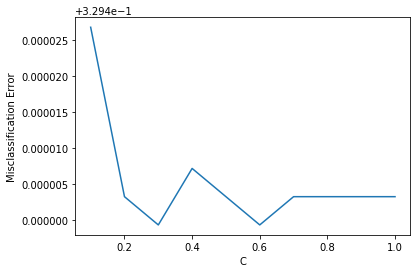

In [35]:
# plot misclassification error vs C
plt.plot(C_values, cv_error)
plt.xlabel('C')
plt.ylabel('Misclassification Error')
plt.show()

In [36]:
clf = LogisticRegression(C = optimal_C)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy =", acc)
confusion_matrix(y_test, y_pred)

Accuracy = 83.00979323359931


array([[ 1441, 17625],
       [  921, 89170]], dtype=int64)

### Feature Selection is not easy if we use the Word2Vec vectorization technique as we are mapping our features in some transformed space